### lecture 20 - RNN Example for Time Series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./dataset/Alcohol_Sales.csv',index_col='DATE',parse_dates=True)

In [3]:
df.index.freq = 'MS'

In [4]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [5]:
df.columns = ['Sales']

<Axes: xlabel='DATE'>

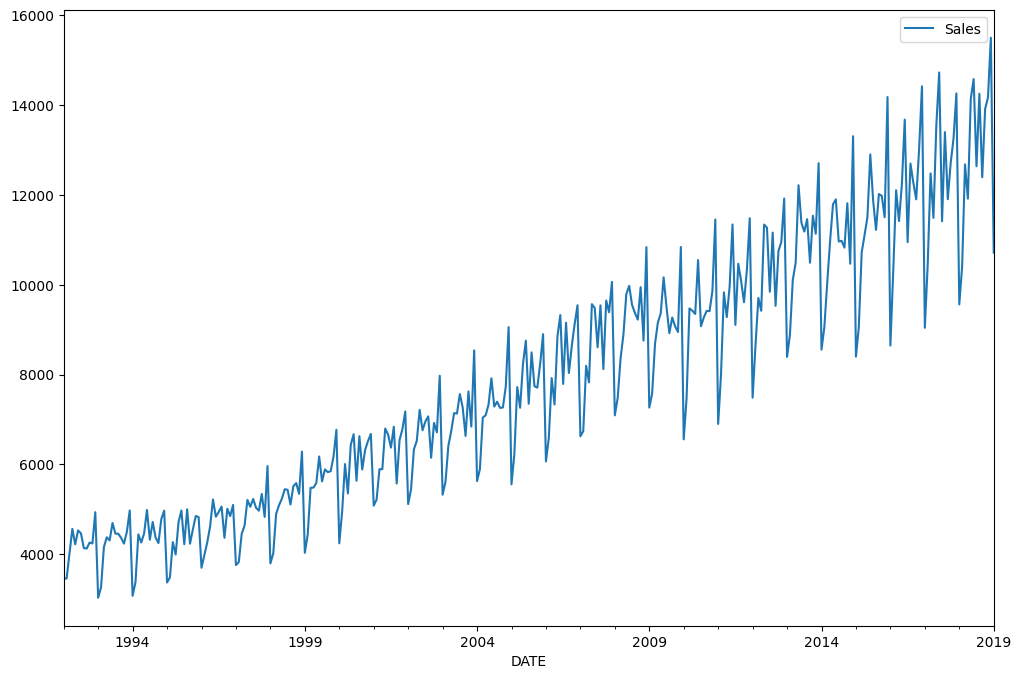

In [6]:
df.plot(figsize=(12,8)) 

can be seen general trend and seasonality

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
results = seasonal_decompose(df['Sales'])

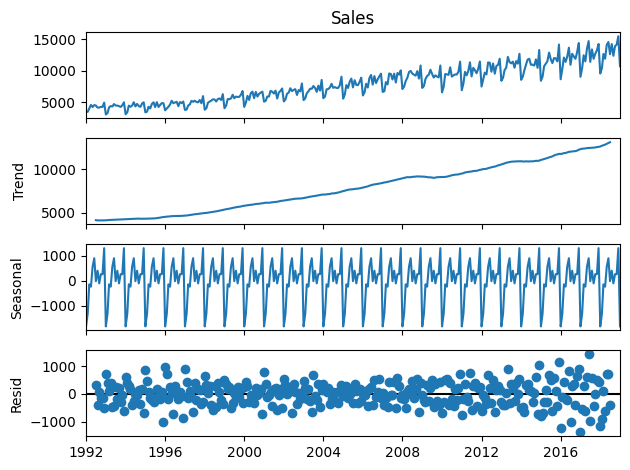

In [9]:
results.plot();

<Axes: xlabel='DATE'>

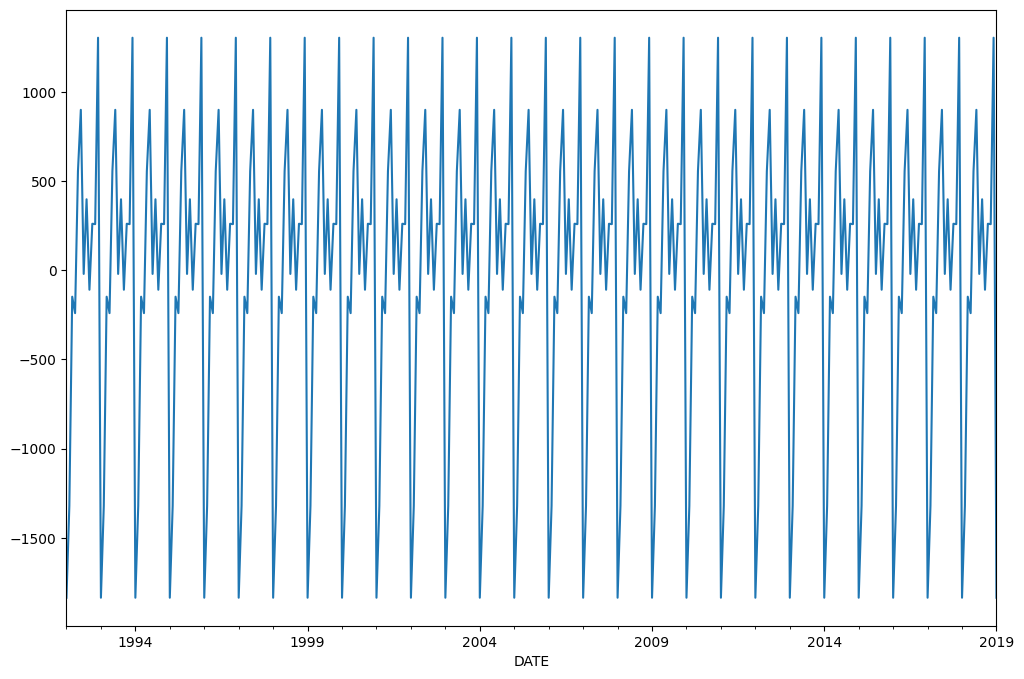

In [10]:
results.seasonal.plot(figsize=(12,8))

#### train and test split

In [11]:
len(df)

325

In [12]:
325-12 # forecast the last year

313

In [13]:
train = df.iloc[:313]

In [14]:
test = df.iloc[313:]

#### example of data scaling

In [15]:
ser = np.array([23,56,2,13,14])

In [16]:
ser.max()

56

In [17]:
ser / ser.max() # now all the data falls between 0 and 1

array([0.41071429, 1.        , 0.03571429, 0.23214286, 0.25      ])

#### data scaling

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler()

In [20]:
scaler.fit(train) 

MinMaxScaler()

fit only on the training data --> it finds the max value in train data

Transform features by scaling each feature to a given range. This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

The transformation is given by:

    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = X_std * (max - min) + min

where min, max = feature_range.

In [21]:
scaled_train = scaler.transform(train) 

In [22]:
scaled_test = scaler.transform(test)

#### time series generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # type: ignore

In [24]:
n_input = 2

In [25]:
n_features = 1

In [26]:
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,
                                batch_size=1) # how many time series batches the generator produces

In [27]:
len(scaled_train)

313

In [28]:
len(generator) # 313 - n_input

311

In [29]:
X,y = generator[0]

In [30]:
X # first 2 point in scaled_train

array([[[0.03658432],
        [0.03649885]]])

In [31]:
y # third point in scaled_train

array([[0.08299855]])

In [32]:
scaled_train[:5]

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ]])

so all it's doing is based off the number of inputs, it went ahed based on the first two point of the scaled_train to predict the third point

#### model creation

In [33]:
from keras.models import Sequential # type: ignore
from keras.layers import Dense # type: ignore
from keras.layers import LSTM # type:ignore Long Short Term Memory unit 

In [34]:
n_input = 12 # 12 months

In [35]:
n_features = 1

In [36]:
train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,
                                batch_size=1)

In [37]:
model = Sequential()

model.add(LSTM(150,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

c:\Users\adepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,351 (356.84 KB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.fit(train_generator,epochs=25)

Epoch 1/25


c:\Users\adepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0474
Epoch 2/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0091
Epoch 3/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0068
Epoch 4/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0069
Epoch 5/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0073
Epoch 6/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0062
Epoch 7/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0050
Epoch 8/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0037
Epoch 9/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030
Epoch 10/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0028
Epoch 11/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021
Epoch 12/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022
Epoch 13/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0021
Epoch 14/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0015
Epoch 15/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0020


In [40]:
model.history.history.keys()

dict_keys(['loss'])

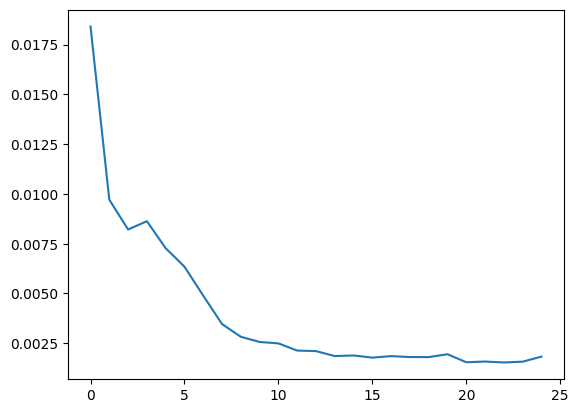

In [41]:
plt.plot(range(len(model.history.history['loss'])),model.history.history['loss'])

#### evaluate on test set

In [42]:
first_eval_batch = scaled_train[-12:]

In [43]:
first_eval_batch # last 12 points of the training set

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [44]:
first_eval_batch.reshape((1,n_input,n_features))

array([[[0.63432772],
        [0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ]]])

In [45]:
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))

In [46]:
model.predict(first_eval_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


array([[0.71812236]], dtype=float32)

that means that given these 12 points, since it is designed to take in 12 points and predict a 13th point it predicst that '0.71812236' shoud be the first point of the test dataset

#### forecast using RNN model

In [47]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:] # used the previous 12 historical points of the train set to predict the first value in the training set
current_batch = first_eval_batch.reshape((1, n_input, n_features)) # reshape this to the format RNN wants(same format as TimeseriesGenerator)

# how far into the future will I forecast ? len(test) 
for i in range(len(test)):
    
    # get prediction 1 time step ahead of historical 12 points([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update current batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


In [48]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:] 
current_batch = first_eval_batch.reshape((1, n_input, n_features)) 

In [49]:
my_first_pred = model.predict(current_batch)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


In [50]:
my_first_pred

array([0.71812236], dtype=float32)

In [51]:
current_batch

array([[[0.63432772],
        [0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ]]])

so, in this case, i want to drop the first value of the current batch('0.63432772') and add on my prediction('0.71812236') at the very end

In [52]:
np.append(current_batch[:,1:,:],[[my_first_pred]],axis=1)

array([[[0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ],
        [0.71812236]]])

#### test predictions

In [53]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:] # used the previous 12 historical points of the train set to predict the first value in the training set
current_batch = first_eval_batch.reshape((1, n_input, n_features)) # reshape this to the format RNN wants(same format as TimeseriesGenerator)

# how far into the future will I forecast ? len(test) 
for i in range(len(test)):
    
    # get prediction 1 time step ahead of historical 12 points([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update current batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [54]:
test_predictions

[array([0.71812236], dtype=float32),
 array([0.84606636], dtype=float32),
 array([0.7943823], dtype=float32),
 array([0.97251713], dtype=float32),
 array([1.0541642], dtype=float32),
 array([0.7815664], dtype=float32),
 array([0.94036216], dtype=float32),
 array([0.807406], dtype=float32),
 array([0.8861628], dtype=float32),
 array([0.93676436], dtype=float32),
 array([1.0126611], dtype=float32),
 array([0.63367736], dtype=float32)]

now i want to invert the scaled test predictions

In [55]:
true_predictions = scaler.inverse_transform(test_predictions)

In [56]:
true_predictions

array([[11432.3135258 ],
       [12929.1302954 ],
       [12324.47822529],
       [14408.47793615],
       [15363.66663909],
       [12174.54509664],
       [14032.29685646],
       [12476.84289044],
       [13398.21880168],
       [13990.20624149],
       [14878.12220228],
       [10444.39147437]])

In [58]:
test.loc[:, 'Predictions'] = true_predictions

In [59]:
test

,Sales,Predictions
DATE,,
2018-02-01,10415,11432.313526
2018-03-01,12683,12929.130295
2018-04-01,11919,12324.478225
2018-05-01,14138,14408.477936
2018-06-01,14583,15363.666639
2018-07-01,12640,12174.545097
2018-08-01,14257,14032.296856
2018-09-01,12396,12476.842890
2018-10-01,13914,13398.218802


<Axes: xlabel='DATE'>

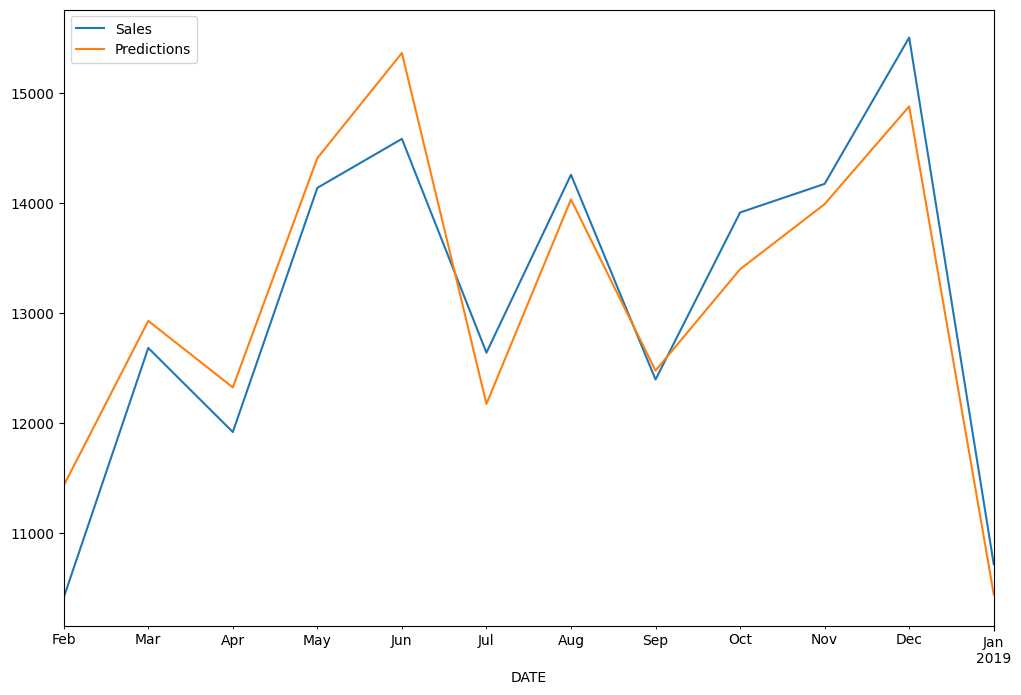

In [60]:
test.plot(figsize=(12,8))